# Comparison of BPC, GPC, and LQR on Linear Dynamical Systems

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import numpy as onp
import jax.random as random
import tigercontrol
from tigercontrol.utils.random import set_key, generate_key
from tigercontrol.environments import Environment
from tigercontrol.controllers import Controller
from jax import grad,jit
import seaborn as sns; sns.set()
import pandas as pd

/Users/johnhallman/mlcourse/mlenv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from controllers.bpc import BPC
from controllers.gpc import GPC
from controllers.lqr import LQR

from environments.lds import LDS

n_runs = 1
alg_name = ['BPC', 'GPC', 'LQR']
color_code = {'BPC': 'blue', 'GPC': 'purple', 'LQR': 'red'}

In [3]:
def plot(title, data, scale = 'linear'):
    fig, axs = plt.subplots(ncols=2, figsize=(15,4))
    axs[0].set_yscale(scale)
    sns.lineplot(x = 'Time', y = 'Instantaneous Cost', hue = 'Algorithm', 
                 data = data, ax = axs[0], ci = 'sd', palette = color_code,
                err_style = 'band').set_title(title)
    axs[1].set_yscale(scale)
    sns.lineplot(x = 'Time', y = 'Average Cost', hue = 'Algorithm', 
                 data = data, ax = axs[1], ci = 'sd', palette = color_code).set_title(title)
    
def to_dataframe(alg, loss, avg_loss, start = 10):
    global T
    return pd.DataFrame(data = {'Algorithm': alg, 'Time': np.arange(start = start, stop = T, dtype=np.float32),
                                'Instantaneous Cost': loss[start:], 'Average Cost': avg_loss[start:]})

In [4]:
def get_regret(T, alg_name, model, x):
    loss = onp.zeros(T)
    avg_regret = onp.zeros(T)
    c_t = 0 # cost of initial function is 0
    for i in range(T):
        u = model.get_action()
        c_t = loss_fn(x, u)
        x = problem.step(u)
        model.update(c_t, x)
        loss[i] = c_t
        if(i):
            avg_regret[i] = avg_regret[i-1] * i / (i+1) + c_t /(i+1)
        else:
            avg_regret[i] = c_t
    data = to_dataframe(alg_name, loss, avg_regret)
    return data

# Sanity Check

For the LDS system, the matrices A, B are generated randomly. The cost function used is c(x, u) = ||x||2 + ||u||2 . The baseline is designed with the pre-fixed matrix K set to 0. In all figures, we plot the averaged results for a fixed random system determined by A, B, for each setting, over 20 experiment runs.

In [5]:
noise_distribution = 'normal'

(a) d = 1

In [6]:
n = 1 # dimension of  the state x 
m = 1 # control dimension
T = 500 # number of timesteps

problem = LDS()

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: np.sum(x.T @ Q @ x + u.T @ R @ u)

In [7]:
K = np.zeros((m, n))
H = 8
delta = 0.5 * H **0.75 / T**0.25

bpc = BPC()
for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [8]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [9]:
lqr = LQR()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

In [10]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])

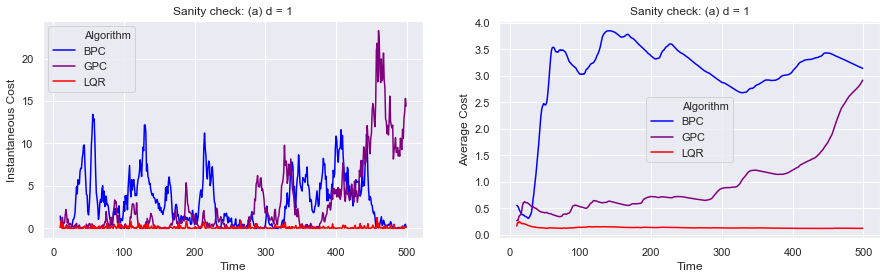

In [11]:
plot('Sanity check: (a) d = 1', all_data)
plt.savefig("sanity_check_a.pdf")

(b) d = 10

In [12]:
n = 10 # dimension of  the state x 
m = 10 # control dimension
T = 1000 # number of timesteps

problem = LDS()

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [13]:
K = np.zeros((m, n))
H = 8
delta = 0.5 * H **0.75 / T**0.25
bpc = BPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [14]:
K = np.zeros((m, n))
H, HH = 8, 16
gpc = GPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [15]:
lqr = LQR()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

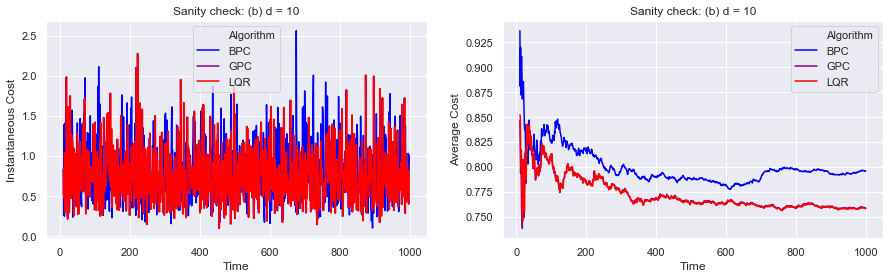

In [16]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])
plot('Sanity check: (b) d = 10', all_data)
plt.savefig("sanity_check_b.pdf")

(c) d = 100

In [17]:
n = 100 # dimension of  the state x 
m = 100 # control dimension
T = 1000 # number of timesteps

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [18]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [19]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [20]:
lqr = LQR()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

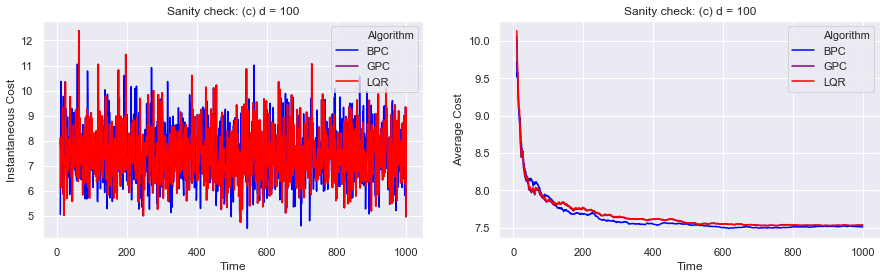

In [21]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])
plot('Sanity check: (c) d = 100', all_data)
plt.savefig("sanity_check_c.pdf")

# Correlated noise experiment

## Gaussian Random Walk

In the first setting, the noise terms are $w_{t+1} ∼ N(w_t,0.03^2)$, and are then clipped to the range [−1, 1].

In [22]:
noise_magnitude = 0.05

In [23]:
def get_next_w(n, x, u, w, t):
    next_w = w + noise_magnitude * random.normal(generate_key(), shape = (n,))
    next_w = np.minimum(np.ones(n), next_w)
    next_w = np.maximum(-np.ones(n), next_w)
    return next_w

In [24]:
## PROBLEM ##
n = 10 # dimension of  the state x 
m = 10 # control dimension
T = 500

problem = LDS()
x = problem.initialize(n, m, noise_distribution = get_next_w)

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [25]:
K = np.zeros((m, n))
H = 8
delta = 0.5 * H **0.75 / T**0.25

bpc = BPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [26]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [27]:
lqr = LQR()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

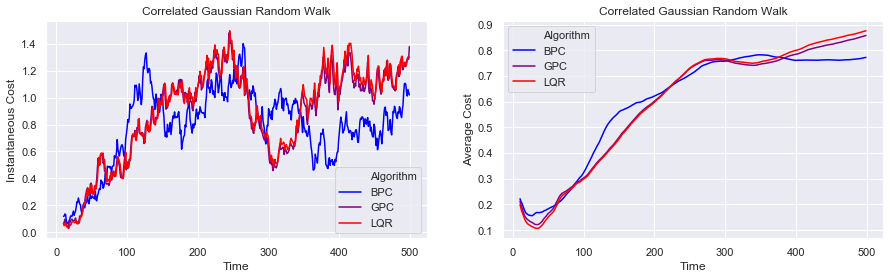

In [28]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])
plot('Correlated Gaussian Random Walk', all_data)
plt.savefig("corr_gauss_rw_quad.pdf")

## Hinge Loss

In [29]:
D = 10 # max value of x/u
loss_fn = lambda x, u: (1/D) * (np.linalg.norm(x) + np.linalg.norm(u))

In [30]:
K = np.zeros((m, n))
H = 8
delta = 0.5 * H **0.75 / T**0.25

bpc = BPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [31]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [32]:
lqr = LQR()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

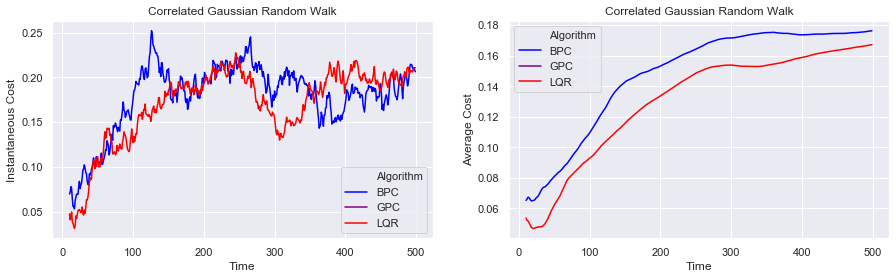

In [33]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])
plot('Correlated Gaussian Random Walk', all_data)
plt.savefig("corr_gauss_rw_hinge.pdf")

## Sine Noise

### Quadratic Loss

In [34]:
noise_magnitude = 0.3

In [35]:
def get_next_w(n, x, u, w, t):
    #return noise_magnitude * np.sin(np.arange(t, t+n)/(2*n*np.pi))
    return noise_magnitude * np.sin(np.arange(t, t+n)/(2*np.sqrt(n)*np.pi))

In [36]:
## PROBLEM ##
n = 10 # dimension of  the state x 
m = 10 # control dimension
T = 500

problem = LDS()

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [37]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [38]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [39]:
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

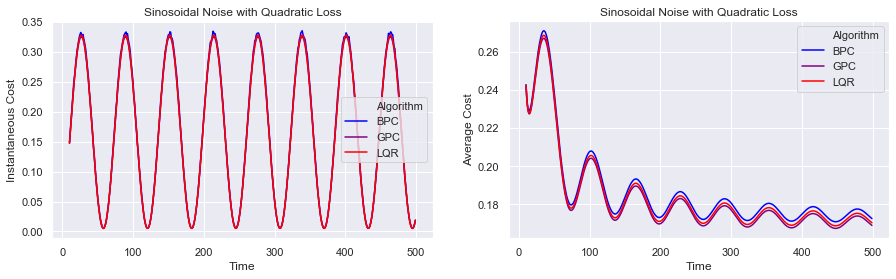

In [40]:
all_data = pd.concat([BPC_data, GPC_data, LQR_data])
plot('Sinosoidal Noise with Quadratic Loss', all_data)
plt.savefig("sin_quad.pdf")

### Hinge Loss

In [41]:
T = 500
D = 10 # max value of x/u
loss_fn = lambda x, u: (1/D) * (np.linalg.norm(x) + np.linalg.norm(u))

In [42]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    if(run == 0):
        BPC_data = get_regret(T, 'BPC', bpc, x)
    else:
        new_data = get_regret(T, 'BPC', bpc, x)
        BPC_data = pd.concat([BPC_data, new_data])

In [43]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    if(run == 0):
        GPC_data = get_regret(T, 'GPC', gpc, x)
    else:
        new_data = get_regret(T, 'GPC', gpc, x)
        GPC_data = pd.concat([GPC_data, new_data])

In [44]:
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x)
    
    if(run == 0):
        LQR_data = get_regret(T, 'LQR', lqr, x)
    else:
        new_data = get_regret(T, 'LQR', lqr, x)
        LQR_data = pd.concat([LQR_data, new_data])

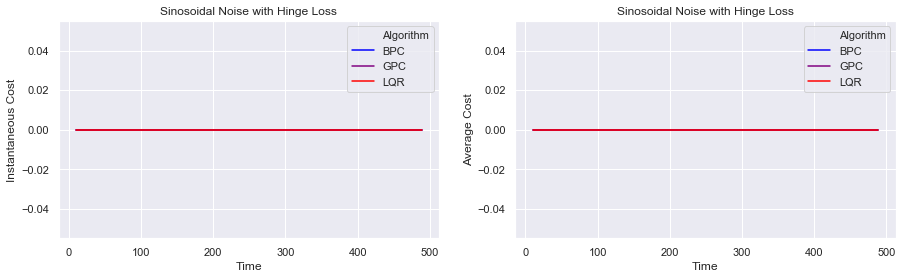

In [45]:
T = T - 10
all_data = pd.concat([to_dataframe('BPC', BPC_loss[10:], BPC_avg_regret[10:]), 
                      to_dataframe('GPC', GPC_loss[10:], GPC_avg_regret[10:]),
                      to_dataframe('LQR', LQR_loss[10:], LQR_avg_regret[10:])])

plot('Sinosoidal Noise with Hinge Loss', all_data)